In [111]:
# Predicting Salaries of KBO League Baseball Players

# -*- coding: utf-8 -*-
%matplotlib inline


# import libararies
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

# data preparation
# Data Source : http://www.statiz.co.kr/
pitcher_file_path = '../data_for_practice/picher_stats_2017.csv'
batter_file_path = '../data_for_practice/batter_stats_2017.csv'

pitcher = pd.read_csv(pitcher_file_path)
pbatter = pd.read_csv(batter_file_path)


# step1 : explore
pitcher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [112]:
pitcher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [113]:
print("pitcher shape :", pitcher.shape)

pitcher shape : (152, 22)


In [114]:
pitcher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

<AxesSubplot:>

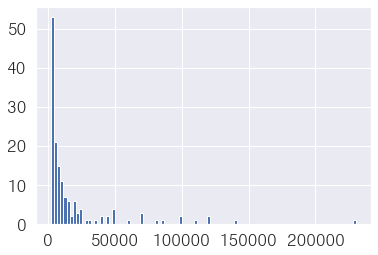

In [115]:
pitcher['연봉(2018)'].hist(bins=100)

In [116]:
# font setting
set(sorted([f.name for f in mpl.font_manager.fontManager.ttflist]))

{'Ami R',
 'Arial',
 'Arial Unicode MS',
 'Bahnschrift',
 'Batang',
 'Book Antiqua',
 'Bookman Old Style',
 'Bookshelf Symbol 7',
 'Bradley Hand ITC',
 'Calibri',
 'Cambria',
 'Candara',
 'Century',
 'Century Gothic',
 'Comic Sans MS',
 'Consolas',
 'Constantia',
 'Corbel',
 'Courier New',
 'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Ebrima',
 'Franklin Gothic Medium',
 'Freestyle Script',
 'French Script MT',
 'Gabriola',
 'Gadugi',
 'Garamond',
 'Georgia',
 'Gulim',
 'HYGothic-Extra',
 'HYGothic-Medium',
 'HYGraphic-Medium',
 'HYGungSo-Bold',
 'HYHeadLine-Medium',
 'HYMyeongJo-Extra',
 'HYPMokGak-Bold',
 'HYPost-Light',
 'HYPost-Medium',
 'HYShortSamul-Medium',
 'HYSinMyeongJo-Medium',
 'Headline R',
 'HoloLens MDL2 Assets',
 'Impact',
 'Ink Free',
 'Javanese Text',
 'Juice ITC',
 'Kristen ITC',
 'Leelawadee',
 'Leelawadee UI',
 'Lucida Console',
 'Lucida Handwriting',
 'Lucida Sans Unicode',
 'MS Gothic',
 'MS Reference San

In [117]:
mpl.rc('font', family='HYGothic-Medium')

<AxesSubplot:>

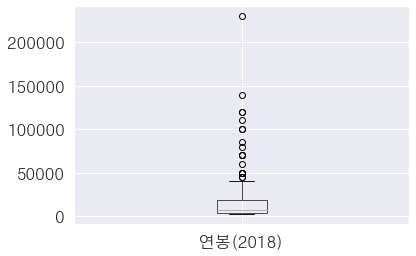

In [118]:
pitcher.boxplot(column=['연봉(2018)'])

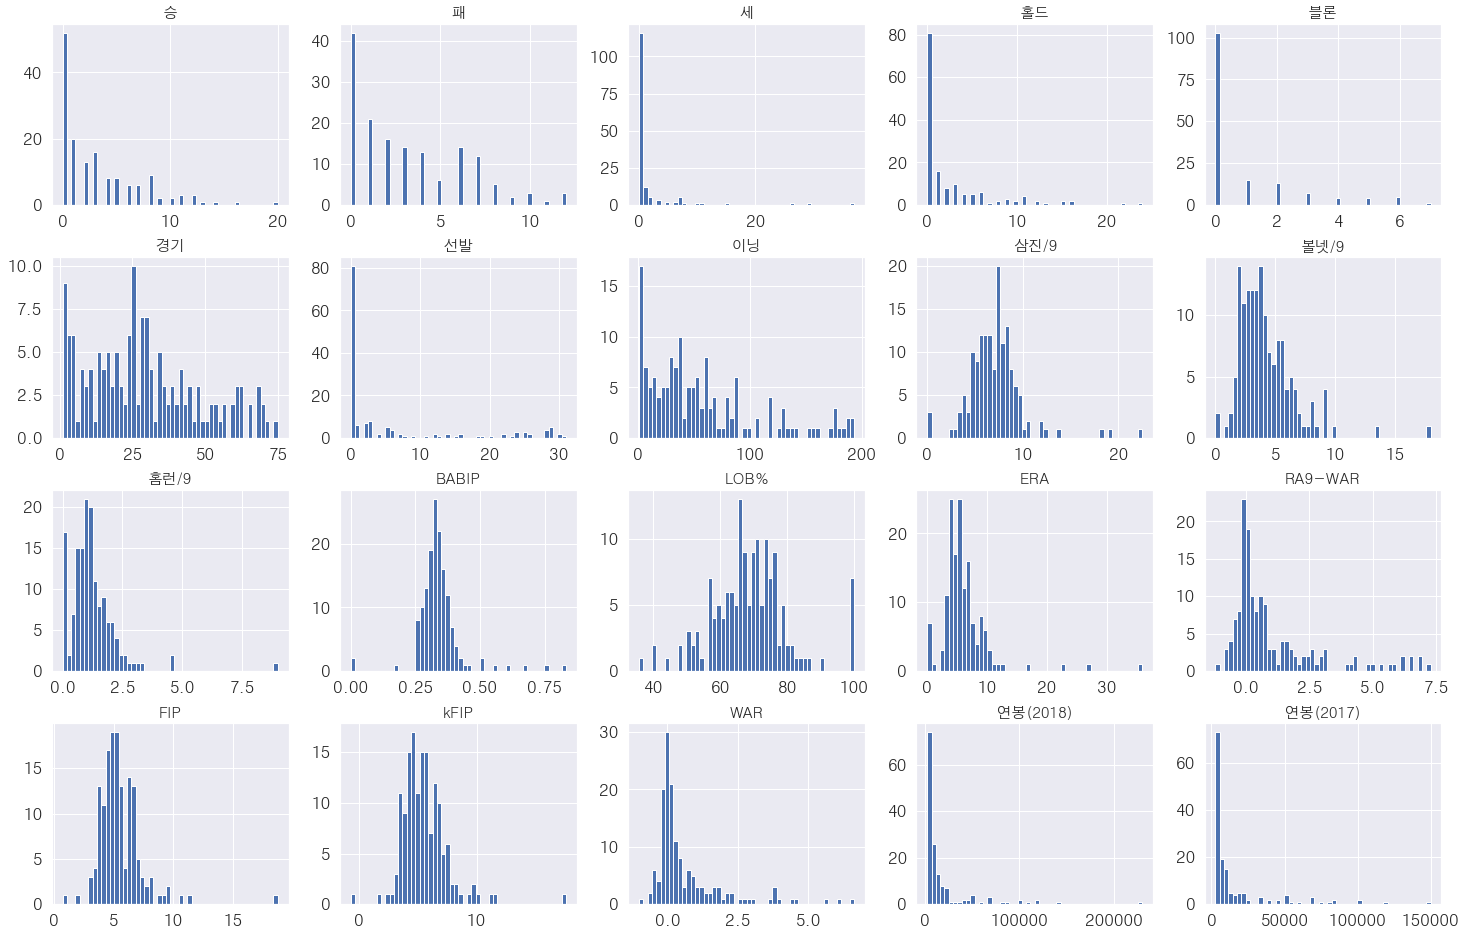

In [125]:
# check the features
pitcher_features_df = pitcher[['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 
                               'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '연봉(2018)', '연봉(2017)']]

# print histograms of each column
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    
    # print subplot (the number of columns)
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i], fontdict={'fontsize': 15, 'fontweight' : 'medium'})
    fig.tight_layout()
    plt.show()

plot_hist_each_column(pitcher_features_df)

In [91]:
# step2 : predict
pd.options.mode.chained_assignment = None

# for feature scaling
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
        
    return df

scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', 
                 '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '연봉(2017)']

pitcher_df = standard_scaling(pitcher, scale_columns)
pitcher_df = pitcher_df.rename(columns = {'연봉(2018)': 'y'})
pitcher_df.head(5)

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


In [92]:
# one-hot encoding (team name)
team_encoding = pd.get_dummies(pitcher_df['팀명'])
print(team_encoding.head(5))
print()
print("-------------------------------------------------------------------------------------------------------------------------------")
print()
pitcher_df = pitcher_df.drop('팀명', axis = 1) # axis = 1 : column
print(pitcher_df)
pitcher_df = pitcher_df.join(team_encoding)
print()
print("-------------------------------------------------------------------------------------------------------------------------------")
print()
print(pitcher_df)

   KIA  KT  LG  NC  SK  두산  롯데  삼성  한화
0    0   0   0   0   1   0   0   0   0
1    0   0   1   0   0   0   0   0   0
2    1   0   0   0   0   0   0   0   0
3    0   0   1   0   0   0   0   0   0
4    0   0   0   0   0   0   1   0   0

-------------------------------------------------------------------------------------------------------------------------------

     선수명         승         패         세        홀드        블론        경기  \
0     켈리  3.313623  1.227145 -0.306452 -0.585705 -0.543592  0.059433   
1     소사  2.019505  2.504721 -0.098502 -0.585705 -0.543592  0.059433   
2    양현종  4.348918  0.907751 -0.306452 -0.585705 -0.543592  0.111056   
3    차우찬  1.760682  1.227145 -0.306452 -0.585705 -0.543592 -0.043811   
4    레일리  2.537153  1.227145 -0.306452 -0.585705 -0.543592  0.059433   
..   ...       ...       ...       ...       ...       ...       ...   
147  장민재 -0.309907  0.588357 -0.306452 -0.585705  0.680497  0.214300   
148  정용운 -0.051084 -0.369825 -0.306452 -0.585705 -0.543592 -

In [93]:
# split data
x = pitcher_df[pitcher_df.columns.difference(['선수명', 'y'])]
y = pitcher_df['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 19)

print("x_train shape :", x_train.shape)
print("x_test shape :", x_test.shape)
print("y_train shape :", y_train.shape)
print("y_test shape :", y_test.shape)

x_train shape : (121, 28)
x_test shape : (31, 28)
y_train shape : (121,)
y_test shape : (31,)


In [94]:
lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)

print(lr.coef_)

[ -1481.01733901   -416.68736601 -94136.23649209  -1560.86205158
   1572.00472193   -747.04952389  -1375.53830289   -523.54687556
   3959.10653661    898.37638984  10272.48746451  77672.53804469
  -2434.38947427   -892.11801281    449.91117164   7612.15661812
   1271.04500059  -2810.5564514    5396.97279896  -4797.30275904
   -250.69773139    236.02530053  19130.59021357    854.02604585
   1301.61974637   3613.84063182   -935.07281796  18144.60099745]


In [95]:
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     44.19
Date:                Sun, 13 Sep 2020   Prob (F-statistic):           7.70e-42
Time:                        14:20:34   Log-Likelihood:                -1247.8
No. Observations:                 121   AIC:                             2552.
Df Residuals:                      93   BIC:                             2630.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.678e+04    697.967     24.036      0.000    1.54e+04    1.82e+04
BABIP      -1481.0173   1293.397     -1.145      0.255   -4049.448    1087.414
ERA         -416.6874   2322.402     -0.179      0.858   -5028.517    4195.143
FIP        -9.414e+04   9.43e+04     -0.998      0.321   -2.81e+05    9.31e+04
KIA          303.1852   2222.099      0.136      0.892   -4109.462    4715.833
KT          3436.0520   2133.084      1.611      0.111    -799.831    7671.935
LG          1116.9978   2403.317      0.465      0.643   -3655.513    5889.509
LOB%       -1375.5383   1564.806     -0.879      0.382   -4482.933    1731.857
NC          1340.5004   2660.966      0.504      0.616   -3943.651    6624.652
RA9-WAR     3959.1065   2931.488      1.351      0.180   -1862.247    9780.460
SK          2762.4237   2243.540      1.231      0.221   -1692.803    7217.650
WAR         1.027e+04   2532.309      4.057      0.000    5243.823    1.53e+04
kFIP        7.767e+04   7.95e+04      0.977      0.331   -8.03e+04    2.36e+05
경기         -2434.3895   2953.530     -0.824      0.412   -8299.515    3430.736
두산           971.9293   2589.849      0.375      0.708   -4170.998    6114.857
롯데          2313.9585   2566.009      0.902      0.370   -2781.627    7409.544
볼넷/9        7612.1566   6275.338      1.213      0.228   -4849.421    2.01e+04
블론          1271.0450   1242.128      1.023      0.309   -1195.576    3737.666
삼성          -946.5092   2482.257     -0.381      0.704   -5875.780    3982.762
삼진/9        5396.9728   7286.221      0.741      0.461   -9072.019    1.99e+04
선발         -4797.3028   5489.352     -0.874      0.384   -1.57e+04    6103.463
세           -250.6977   1295.377     -0.194      0.847   -2823.059    2321.663
승            236.0253   2215.264      0.107      0.915   -4163.049    4635.100
연봉(2017)    1.913e+04   1270.754     15.055      0.000    1.66e+04    2.17e+04
이닝           854.0260   6623.940      0.129      0.898   -1.23e+04     1.4e+04
패           1301.6197   1935.935      0.672      0.503   -2542.763    5146.003
한화          5477.8879   2184.273      2.508      0.014    1140.355    9815.421
홀드          -935.0728   1637.923     -0.571      0.569   -4187.663    2317.518
홈런/9        1.814e+04   1.68e+04      1.082      0.282   -1.52e+04    5.14e+04
==============================================================================
Omnibus:                       28.069   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.274
Skew:                          -0.405   Prob(JB):                     6.52e-43
Kurtosis:                       9.155   Cond. No.                     4.06e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

[Text(0, 0, 'const'),
 Text(1, 0, 'BABIP'),
 Text(2, 0, 'ERA'),
 Text(3, 0, 'FIP'),
 Text(4, 0, 'KIA'),
 Text(5, 0, 'KT'),
 Text(6, 0, 'LG'),
 Text(7, 0, 'LOB%'),
 Text(8, 0, 'NC'),
 Text(9, 0, 'RA9-WAR'),
 Text(10, 0, 'SK'),
 Text(11, 0, 'WAR'),
 Text(12, 0, 'kFIP'),
 Text(13, 0, '경기'),
 Text(14, 0, '두산'),
 Text(15, 0, '롯데'),
 Text(16, 0, '볼넷/9'),
 Text(17, 0, '블론'),
 Text(18, 0, '삼성'),
 Text(19, 0, '삼진/9'),
 Text(20, 0, '선발'),
 Text(21, 0, '세'),
 Text(22, 0, '승'),
 Text(23, 0, '연봉(2017)'),
 Text(24, 0, '이닝'),
 Text(25, 0, '패'),
 Text(26, 0, '한화'),
 Text(27, 0, '홀드'),
 Text(28, 0, '홈런/9')]

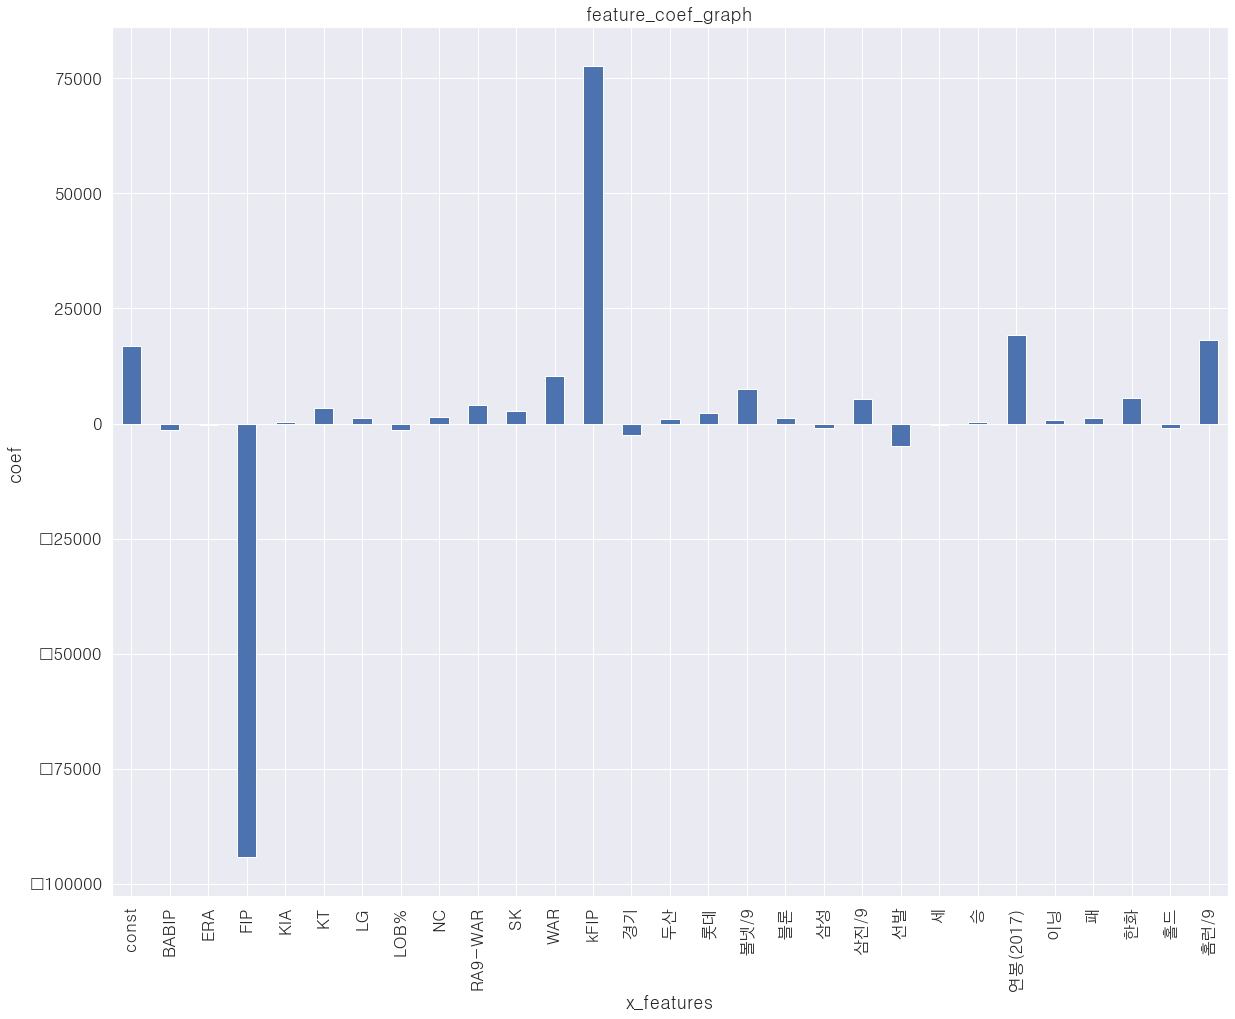

In [96]:
# feature_coef_graph

mpl.rc('font', family='HYGothic-Medium')
plt.rcParams['figure.figsize'] = [20, 16]

# return to list
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

x_labels = model.params.index.tolist()

ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

In [97]:
# evaluate 'R2'

x = pitcher_df[pitcher_df.columns.difference(['선수명', 'y'])]
y = pitcher_df['y']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 19)

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)

print("R2 score(train) :", model.score(x_train, y_train))
print()
print("R2 score(test) :", model.score(x_test, y_test))

R2 score(train) : 0.9276949405576705

R2 score(test) : 0.8860171644977815


In [98]:
# evaluate 'RMSE
y_prediction = lr.predict(x_train)
print("RMSE score(train) :",sqrt(mean_squared_error(y_train, y_prediction)))
print()
y_prediction = lr.predict(x_test)
print("RMSE score(test) :",sqrt(mean_squared_error(y_test, y_prediction)))

RMSE score(train) : 7282.7186847463745

RMSE score(test) : 14310.696436889151


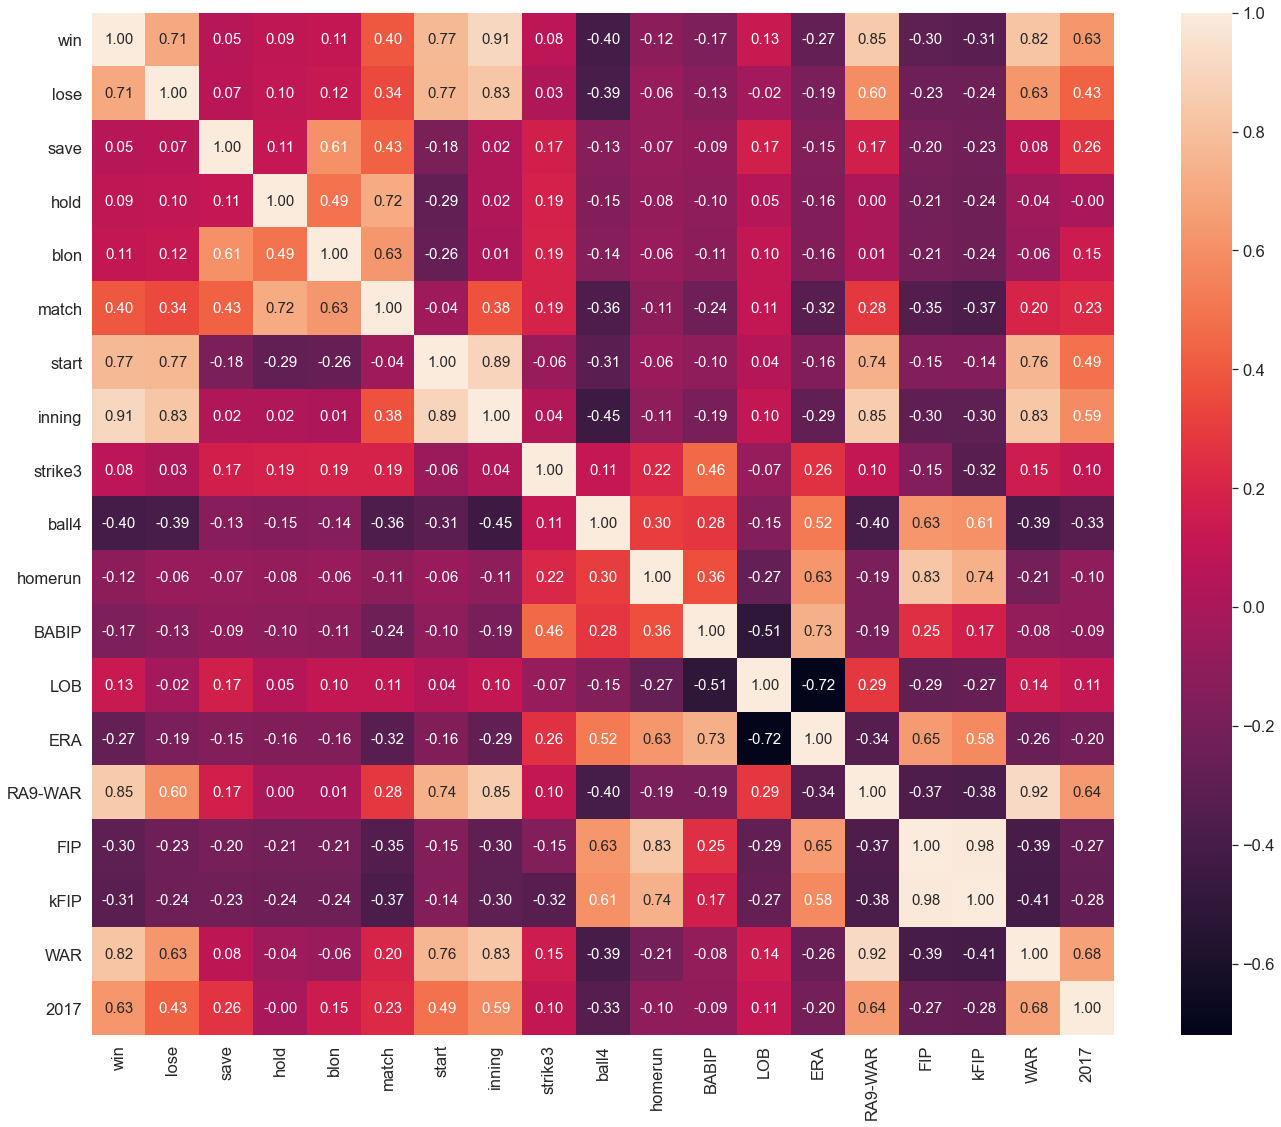

In [99]:
import seaborn as sns

corr = pitcher_df[scale_columns].corr(method='pearson')
show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match', 'start', 'inning', 'strike3', 
             'ball4', 'homerun', 'BABIP', 'LOB', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '2017']

# visualize heatmap
plt.rc('font', family='HYGothic-Medium')
sns.set(font_scale = 1.5)

hm = sns.heatmap(corr.values, cbar = True, annot = True, square = True, fmt = '.2f', 
                 annot_kws = {'size':15}, yticklabels=show_cols, xticklabels=show_cols)

plt.tight_layout()
plt.show()


In [100]:
# check Multicollinearity with vif(variance inflation factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['features'] = x.columns
vif.round(1)

,VIF Factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


In [101]:
# feature selection, train again

x = pitcher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
y = pitcher_df['y']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=19)


# R2
lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)

print("R2 score(train) :", model.score(x_train, y_train))
print("R2 score(test) :", model.score(x_test, y_test))
print()

# RMSE
y_prediction = lr.predict(x_train)
print("RMSE score(train) :",sqrt(mean_squared_error(y_train, y_prediction)))
y_prediction = lr.predict(x_test)
print("RMSE score(test) :",sqrt(mean_squared_error(y_test, y_prediction)))



R2 score(train) : 0.9150591192570362
R2 score(test) : 0.9038759653889866

RMSE score(train) : 7893.462873347693
RMSE score(test) : 13141.866063591076


In [102]:
# VIF

x = pitcher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

,VIF Factor,features
0,1.9,FIP
1,2.1,WAR
2,1.9,볼넷/9
3,1.1,삼진/9
4,1.9,연봉(2017)


In [103]:
# visualize result ( predict vs real )
# player - real 2018 - predict 2018 - 2017

x = pitcher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
predict_2018_salary = lr.predict(x)
pitcher_df['예측연봉(2018)'] = pd.Series(predict_2018_salary)


# read the original data
pitcher = pd.read_csv(pitcher_file_path)
pitcher = pitcher[['선수명', '연봉(2017)']]

In [104]:
# join
result_df = pitcher_df.sort_values(by = ['y'], ascending=False)
result_df.drop(['연봉(2017)'], axis = 1, inplace=True, errors='ignore')
result_df = result_df.merge(pitcher, on=['선수명'], how='left')
result_df = result_df[['선수명', 'y', '예측연봉(2018)', '연봉(2017)']]
result_df.columns = ['선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)']

result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df.head(10)

,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,0,양현종,230000,163930.148696,150000
1,1,켈리,140000,120122.822204,85000
2,2,소사,120000,88127.019455,50000
3,4,레일리,111000,102253.697589,85000
4,7,피어밴드,85000,58975.725734,35000
5,13,배영수,50000,56873.662417,55000
6,21,안영명,35000,22420.790838,20000
7,22,채병용,30000,21178.955105,25000
8,23,류제국,29000,45122.360087,35000
9,24,박정진,25000,29060.748299,33000


<AxesSubplot:xlabel='선수명'>

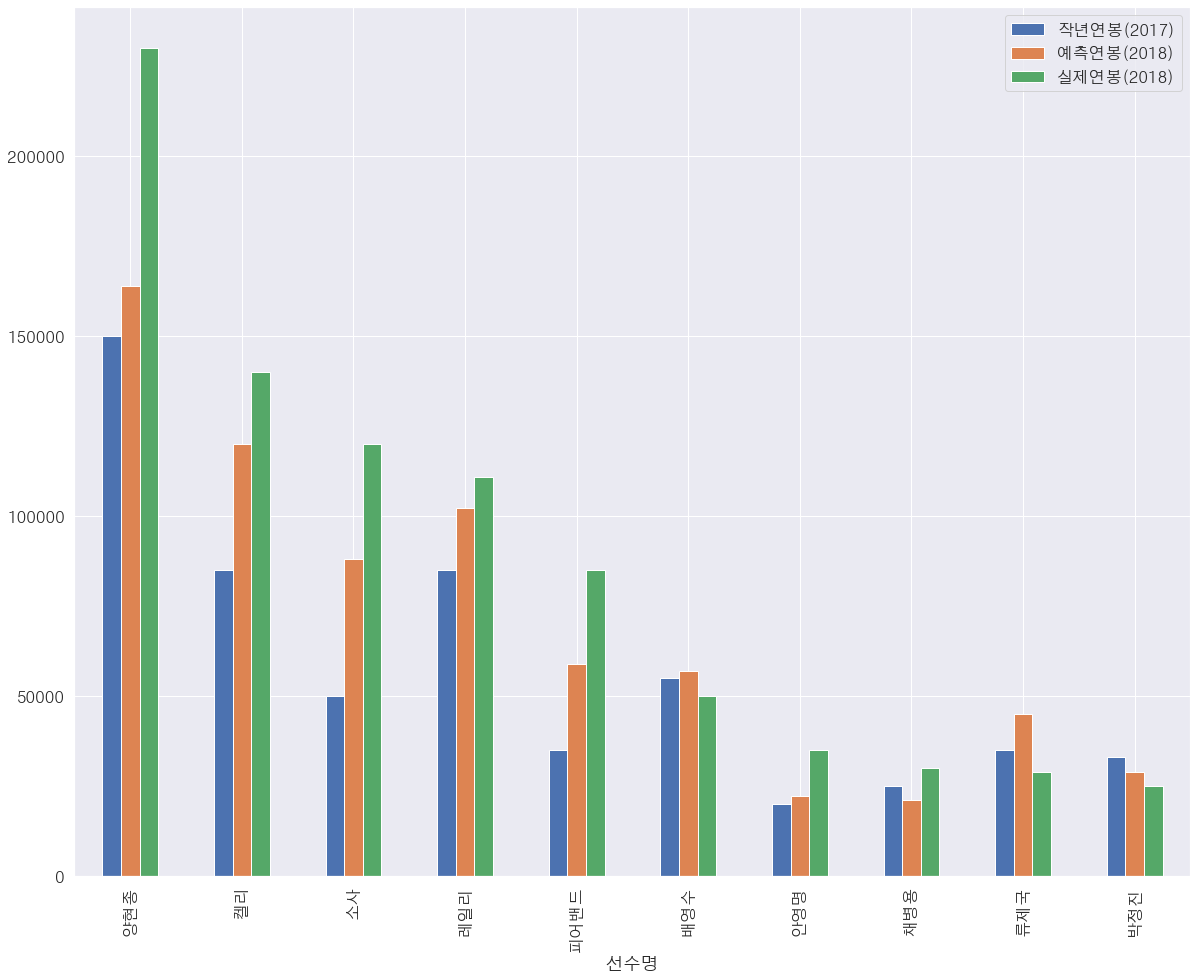

In [105]:
# graph
mpl.rc('font', family = 'HYGothic-Medium')
result_df.plot(x='선수명', y=['작년연봉(2017)', '예측연봉(2018)', '실제연봉(2018)'], kind = 'bar')